In [6]:
import matplotlib.pyplot as plt
import os
import numpy as np
import h5py
from astropy.constants import M_sun
M_sun_g = M_sun.value*1e3
import pandas as pd
import glob as glob
import WinNet_output
from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import random
import importlib
import sys
import yt
yt.set_log_level('ERROR')
import Snapshot2D
import WinNet_output

In [7]:
importlib.reload(Snapshot2D) #in order to not stop the kernel and still update the functionalities in case WinNet_object will be developed further
from Snapshot2D import Snapshot2D

In [8]:
importlib.reload(WinNet_output) #in order to not stop the kernel and still update the functionalities in case WinNet_object will be developed further
from WinNet_output import WinNet_output

# This is a (growing) collection of plots/... to analyze and visualize the results of postprocessing the nucleosynthesis done by WinNet

#### The analysis depends on the class WinNet_output, which generally reads in the single directories with tracer, seed, mainout, finabs, ... 
More on that in the README (work in progress)

#### This Notebook includes:

i) calculation and visualization of the composition of the entire ejected matter (weighted mass fraction/ summed up mass plotted against Z or A)

ii) (Double-) Histograms to visualize the composition/.. of the ejected matter at NSE freeze out 

iii) Function to isolate and therefore analyse the  'neutrino processed' tracers (definition further down)

### first step: give path to the WinNet run and 'clean' them from failed calculations (due do negative expansion velocity/ end-temperature above winnet starting temp/ ....)

In [9]:
#functions to clean a WinNet run (weed out single directories which threw errors for whatever reason)

def file_has_data_quick(main_file, max_bytes=8192):
    with open(main_file, "rb") as f:
        chunk = f.read(max_bytes).decode(errors="ignore")
    for line in chunk.splitlines():
        line = line.strip()
        if not line.startswith("#") and line:
            return True
    return False

def clean_WinNet_run(path_to_workdir):
    cleaned_paths, skipped_err_dirs = [], []

    path_to_single_dirs = sorted([
        os.path.join(path_to_workdir, d)
        for d in os.listdir(path_to_workdir)
        if os.path.isdir(os.path.join(path_to_workdir, d))
    ])

    for path in tqdm(path_to_single_dirs):
        # 1. skip if ERR marker
        if os.path.isfile(os.path.join(path, "ERR")):
            skipped_err_dirs.append(path)
            continue

        # 2. check mainout.dat* exists and has data
        main_files = glob.glob(os.path.join(path, "mainout.dat*"))
        if not main_files or not file_has_data_quick(main_files[0]):
            skipped_err_dirs.append(path)
            continue

        # 3. check at least one tracer* file exists
        if not glob.glob(os.path.join(path, "tracer*.dat")):
            skipped_err_dirs.append(path)
            continue

        # 4. check WinNet_data*.h5 exists
        if not glob.glob(os.path.join(path, "WinNet_data*.h5")):
            skipped_err_dirs.append(path)
            continue

        cleaned_paths.append(path)

    return cleaned_paths, skipped_err_dirs

#### Paths to WinNet outputs

In [10]:
#paths to WinNet runs:
#2D
S15_2D_1ktr_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/new_S15_1ktr_bwd_nf1_7GK'

#1D runs
S15_1D_750tr_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_750tr_1_nf0_10GK'

In [11]:
#clean the runs:
S15_2D_1ktr_clean, S15_2D_1ktr_err_dirs = clean_WinNet_run(S15_2D_1ktr_path)
S15_1D_750tr_clean, S15_1D_750tr_err_dirs = clean_WinNet_run(S15_1D_750tr_path)

  0%|          | 0/3536 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [212]:
print(len(HeS_2D_10ktr_nf0_10GK_error_dirs))

343


In [183]:
#1k tr
HeS_2D_1ktr_nf1_7GK_792ms_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/HeS_s13.8/1k_nf1_7GK_792ms_snaps'
HeS_2D_1ktr_nf1_7GK_792ms_clean, HeS_2D_1ktr_nf1_7GK_792ms_error_dirs = clean_WinNet_run(HeS_2D_1ktr_nf1_7GK_792ms_path)

100%|██████████| 2387/2387 [00:13<00:00, 171.85it/s]


In [193]:
#10ktr
HeS_2D_10ktr_nf1_7GK_792ms_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/HeS_s13.8/10k_nf1_7GK_792ms_snaps'
HeS_2D_10ktr_nf1_7GK_792ms_clean, HeS_2D_10ktr_nf1_7GK_792ms_error_dirs = clean_WinNet_run(HeS_2D_10ktr_nf1_7GK_792ms_path)


100%|██████████| 14324/14324 [03:33<00:00, 67.01it/s] 


In [213]:
HeS_2D_1ktr_nf1_7GK_792ms_rn16_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/HeS_BURN/1k_nf1_7GK_792ms_snaps'
HeS_2D_1ktr_nf1_7GK_792ms_rn16_clean, HeS_2D_1ktr_nf1_7GK_792ms_rn16_error_dirs = clean_WinNet_run(HeS_2D_1ktr_nf1_7GK_792ms_rn16_path)

100%|██████████| 2070/2070 [03:57<00:00,  8.71it/s]


In [224]:
#10ktr
HeS_2D_10ktr_nf1_7GK_792ms_rn16_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/HeS_BURN/10k_nf1_7GK_792ms_snaps'
HeS_2D_10ktr_nf1_7GK_792ms_rn16_clean, HeS_2D_10ktr_nf1_7GK_792ms_rn16_error_dirs = clean_WinNet_run(HeS_2D_10ktr_nf1_7GK_792ms_rn16_path)

100%|██████████| 14782/14782 [00:35<00:00, 415.31it/s]


#### All further functions/ plotting cells etc. expect a cleaned list of output dirs

## 1) Calculation and Visualization of weighted overall abundances/massfractions and summed up ejected mass in terms of Z or A

In [12]:
def overall_composition(clean_path_to_WinNet_out, with_snapshots=False, nr_snapshots=None):
    """
    Compute mass-weighted, summed abundances across many WinNet tracer outputs.
    If with_snapshots=True also build the same weighted quantities for every
    snapshot that carries snapshot_composition data.
    Returns
    -------
    total_mass,
    (A_data, Z_data),                 # final abundances
    snapshot_data,                    # only if with_snapshots=True
    nr_snapshots                      # only if with_snapshots=True
    """
    # ----------------------------------------------------------
    # initialise final-abundance arrays
    # ----------------------------------------------------------
    all_Z = np.arange(0, 120, dtype=int)
    all_X_el = np.zeros(120)
    all_Y_el = np.zeros(120)
    all_M_el = np.zeros(120)

    all_A = np.arange(0, 240, dtype=int)          # index == mass number
    all_X = np.zeros(240)
    all_Y = np.zeros(240)
    all_M = np.zeros(240)

    # ----------------------------------------------------------
    # initialise snapshot buffers (only if requested)
    # ----------------------------------------------------------
    if with_snapshots:
        # we will accumulate *weighted* sums for every time step
        snapshot_sums = None          # dict  t -> {'X':..., 'Y':..., 'M':..., 'mass':0}
        unique_times  = None          # keeps order of appearance
    else:
        snapshot_sums = None
        unique_times  = None

    total_mass = 0.0
    masses     = []
    missing_snaptimes = []
    
    
    # ----------------------------------------------------------
    # loop over tracers
    # ----------------------------------------------------------
    for i, wn_out_path in tqdm(enumerate(clean_path_to_WinNet_out)):
        
        wn = WinNet_output(wn_out_path,
                           want_finabs_info=True,
                           want_tracer_info=True,
                           has_snapshots = with_snapshots)
        m = wn.mass
        masses.append(m)
        total_mass += m

        # ------------------------------------------------------
        # final abundances – already existing code
        # ------------------------------------------------------
        vals_A        = wn.finabsum["A"]
        all_X[vals_A] += wn.finabsum["X"] * m
        all_Y[vals_A] += wn.finabsum["Y"] * m
        all_M[vals_A] += wn.finabsum["X"] * m

        vals_Z          = wn.finabelem["Z"]
        all_X_el[vals_Z] += wn.finabelem["X"] * m
        all_Y_el[vals_Z] += wn.finabelem["Y"] * m
        all_M_el[vals_Z] += wn.finabelem["X"] * m

        # ------------------------------------------------------------------
        # inside overall_composition_withsnaps, snapshot section
        # ------------------------------------------------------------------
        if with_snapshots and hasattr(wn, 'snapshot_times'):
            # --- 1. first tracer sets the master time grid -----------------
            if unique_times is None:
                unique_times = wn.snapshot_times
                snapshot_sums = {t: {'X_A': np.zeros(240),
                                      'Y_A': np.zeros(240),
                                      'M_A': np.zeros(240),
                                      'X_Z': np.zeros(120),
                                      'Y_Z': np.zeros(120),
                                      'M_Z': np.zeros(120),
                                      'mass': 0.0} for t in unique_times}

            # --- 2. build a set for fast lookup ----------------------------
            times_in_this_tracer = set(wn.snapshot_times)
            # --- 3. loop over master grid and accumulate only if present ---
            for t in unique_times:
                if t not in times_in_this_tracer:
                    # ---- missing time: warn once per tracer -----------------
                    missing_snaptimes.append(f"Tracer {wn_out_path} lacks snapshot t={t}")
                    continue          # skip this (tracer, time) pair
        
                # ---- get index inside this tracer's list -------------------
                t_idx = np.where(wn.snapshot_times == t)[0][0]   # safe: t exists
                # ---- A-based data -----------------------------------------
                if hasattr(wn, 'snapshot_composition'):
                    snap = wn.snapshot_composition[t_idx]
                    Y_A  = snap["Y"]
                    A    = snap["A"]
                    X_A  = snap.get("X", Y_A * A)
        
                    snapshot_sums[t]['X_A'][A] += X_A * m
                    snapshot_sums[t]['Y_A'][A] += Y_A * m
                    snapshot_sums[t]['M_A'][A] += X_A * m
        
                # ---- Z-based data -----------------------------------------
                if hasattr(wn, 'snapshot_composition_elem'):
                    snap_z = wn.snapshot_composition_elem[t_idx]
                    Y_Z    = snap_z["Y"]
                    Z      = snap_z["Z"]
                    X_Z    = snap_z.get("X", Y_Z * Z)
        
                    snapshot_sums[t]['X_Z'][Z] += X_Z * m
                    snapshot_sums[t]['Y_Z'][Z] += Y_Z * m
                    snapshot_sums[t]['M_Z'][Z] += X_Z * m

        
                # ---- mass contribution of this tracer to this time --------
                snapshot_sums[t]['mass'] += m


    # ------------------------------------------------------------------
    # normalise final abundances
    # ------------------------------------------------------------------
    non_zero_A = np.nonzero(all_X)[0]
    non_zero_Z = np.nonzero(all_X_el)[0]
    last_A = non_zero_A[-1] if non_zero_A.size else 0
    last_Z = non_zero_Z[-1] if non_zero_Z.size else 0

    all_X /= total_mass
    all_Y /= total_mass
    all_X_el /= total_mass
    all_Y_el /= total_mass

    A_data = {
        'A': all_A[:last_A + 2],
        'X': all_X[:last_A + 2],
        'Y': all_Y[:last_A + 2],
        'M': all_M[:last_A + 2],
    }
    
    Z_data = {
        'Z': all_Z[:last_Z + 2],
        'X_Z': all_X_el[:last_Z + 2],
        'Y_Z': all_Y_el[:last_Z + 2],
        'M_Z': all_M_el[:last_Z + 2],
    }


    # ------------------------------------------------------------------
    # build snapshot return structure (if requested)
    # ------------------------------------------------------------------
    if with_snapshots:
        nr_snaps = len(unique_times) if unique_times is not None else 0
        snapshot_data = []
        for t in unique_times:
            sums = snapshot_sums[t]
            m    = sums['mass']
            # normalise
            X_A = sums['X_A'] / m
            Y_A = sums['Y_A'] / m
            M_A = sums['M_A'] / m
            X_Z = sums['X_Z'] / m
            Y_Z = sums['Y_Z'] / m
            M_Z = sums['M_Z'] / m

            # trim trailing zeros exactly like final abundances
            last_A_snap = np.nonzero(X_A)[0][-1] if np.count_nonzero(X_A) else 0
            last_Z_snap = np.nonzero(X_Z)[0][-1] if np.count_nonzero(X_Z) else 0

            snapshot_data.append({
                't': t,
                'A': np.arange(240)[:last_A_snap + 2],
                'X': X_A[:last_A_snap + 2],
                'Y': Y_A[:last_A_snap + 2],
                'M': M_A[:last_A_snap + 2],
                'Z': np.arange(120)[:last_Z_snap + 2],
                'X_Z': X_Z[:last_Z_snap + 2],
                'Y_Z': Y_Z[:last_Z_snap + 2],
                'M_Z': M_Z[:last_Z_snap + 2],
            })
        return total_mass, A_data, Z_data, snapshot_data, nr_snaps, missing_snaptimes
    else:
        return total_mass, A_data, Z_data

#### Example 2D S15 run 

In [14]:
S15_2D_1ktr_out = overall_composition(S15_2D_1ktr_clean)

(S15_2D_1ktr_total_mass,S15_2D_1ktr_finabs, S15_2D_1ktr_finabselem) = S15_2D_1ktr_out

0it [00:00, ?it/s]

In [16]:
print(f'Overall mass of the ejecta: {S15_2D_1ktr_total_mass/M_sun_g:.2f} M_sun')

Overall mass of the ejecta: 0.11 M_sun


In [ ]:
HeS_2D_10ktr_nf1_10GK_800ms_total_mass,HeS_2D_10ktr_nf1_10GK_800ms_finabs, HeS_2D_10ktr_nf1_10GK_800ms_finabselem,HeS_2D_10ktr_nf1_10GK_800ms_snapdata, HeS_2D_10ktr_nf1_10GK_800ms_nr_snap, HeS_2D_10ktr_nf1_10GK_800ms_missing_snaptimes = overall_composition_withsnaps(HeS_2D_10ktr_nf1_10GK_800ms_clean, with_snapshots=True,nr_snapshots=3)

In [ ]:
HeS_2D_1ktr_nf1_7GK_792ms_out = overall_composition_withsnaps(HeS_2D_1ktr_nf1_7GK_792ms_clean, True, 1)

In [194]:
(HeS_2D_1ktr_nf1_7GK_792ms_total_mass,HeS_2D_1ktr_nf1_7GK_792ms_finabs, 
 HeS_2D_1ktr_nf1_7GK_792ms_finabselem,HeS_2D_1ktr_nf1_7GK_792ms_snapdata, 
 HeS_2D_1ktr_nf1_7GK_792ms_nr_snap, HeS_2D_1ktr_nf1_7GK_792ms_missing_snaptimes) = HeS_2D_1ktr_nf1_7GK_792ms_out

In [195]:
HeS_2D_10ktr_nf1_7GK_792ms_out = overall_composition_withsnaps(HeS_2D_10ktr_nf1_7GK_792ms_clean, True, 1)

(HeS_2D_10ktr_nf1_7GK_792ms_total_mass,HeS_2D_10ktr_nf1_7GK_792ms_finabs, 
 HeS_2D_10ktr_nf1_7GK_792ms_finabselem,HeS_2D_10ktr_nf1_7GK_792ms_snapdata, 
 HeS_2D_10ktr_nf1_7GK_792ms_nr_snap, HeS_2D_10ktr_nf1_7GK_792ms_missing_snaptimes) = HeS_2D_10ktr_nf1_7GK_792ms_out

13901it [04:21, 53.11it/s]


In [215]:
HeS_2D_1ktr_nf1_7GK_792ms_rn16_out = overall_composition_withsnaps(HeS_2D_1ktr_nf1_7GK_792ms_rn16_clean, True, 1)

(HeS_2D_1ktr_nf1_7GK_792ms_rn16_total_mass,HeS_2D_1ktr_nf1_7GK_792ms_rn16_finabs, 
 HeS_2D_1ktr_nf1_7GK_792ms_rn16_finabselem,HeS_2D_1ktr_nf1_7GK_792ms_rn16_snapdata, 
 HeS_2D_1ktr_nf1_7GK_792ms_rn16_nr_snap, HeS_2D_1ktr_nf1_7GK_792ms_rn16_missing_snaptimes) = HeS_2D_1ktr_nf1_7GK_792ms_rn16_out

1759it [02:11, 13.41it/s]


In [225]:
HeS_2D_10ktr_nf1_7GK_792ms_rn16_out = overall_composition_withsnaps(HeS_2D_10ktr_nf1_7GK_792ms_rn16_clean, True, 1)

(HeS_2D_10ktr_nf1_7GK_792ms_rn16_total_mass,HeS_2D_10ktr_nf1_7GK_792ms_rn16_finabs, 
 HeS_2D_10ktr_nf1_7GK_792ms_rn16_finabselem,HeS_2D_10ktr_nf1_7GK_792ms_rn16_snapdata, 
 HeS_2D_10ktr_nf1_7GK_792ms_rn16_nr_snap, HeS_2D_10ktr_nf1_7GK_792ms_rn16_missing_snaptimes) = HeS_2D_10ktr_nf1_7GK_792ms_rn16_out

14119it [11:15, 20.91it/s]


#### plotting S15

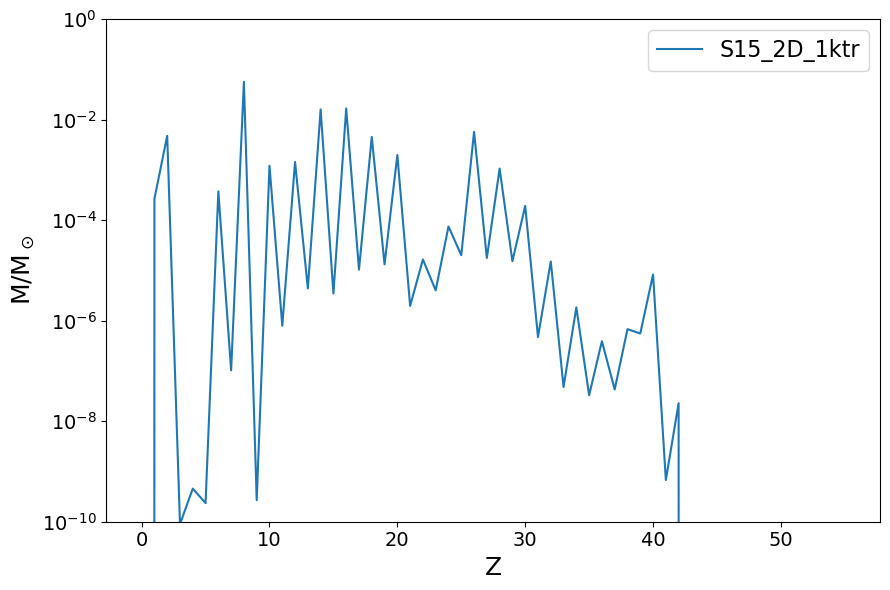

In [18]:
#finabs of Z plot:
plt.figure(figsize = (9,6))

#S15:
#2D_1ktr

plt.plot(S15_2D_1ktr_finabselem['Z'], S15_2D_1ktr_finabselem['M_Z']/M_sun_g, label = 'S15_2D_1ktr')

plt.xlabel('Z', fontsize = 18)
plt.ylabel(r'M/M$_\odot$', fontsize = 18)
plt.ylim(1e-10, 1)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.yscale('log')

plt.tick_params(axis='both', labelsize=14)

plt.tight_layout()

In [21]:
#Later

In [171]:
#read in composition from snapshot

HeS_792ms = Snapshot2D('/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/HeS_s13.8/HeS_rn16e_hdf5_plt_cnt_0792', ['temp', 'dens', 'ye', 'ener', 'gpot', "velx", 'vely'], only_leafs=True, with_rn16 = True)

In [172]:
print(HeS_792ms.currentSimTime())

HeS_792ms_ejec_M_fromplt, HeS_792ms_unbound_composition_fromplt = HeS_792ms.get_unbound_composition()

0.7920000480195852


In [198]:
print(HeS_792ms_ejec_M_fromplt/M_sun_g)
print(HeS_2D_1ktr_nf1_7GK_792ms_total_mass/M_sun_g)
print(HeS_2D_10ktr_nf1_7GK_792ms_total_mass/M_sun_g)

0.02750308796778152
0.02758928348351114
0.027562286716501815


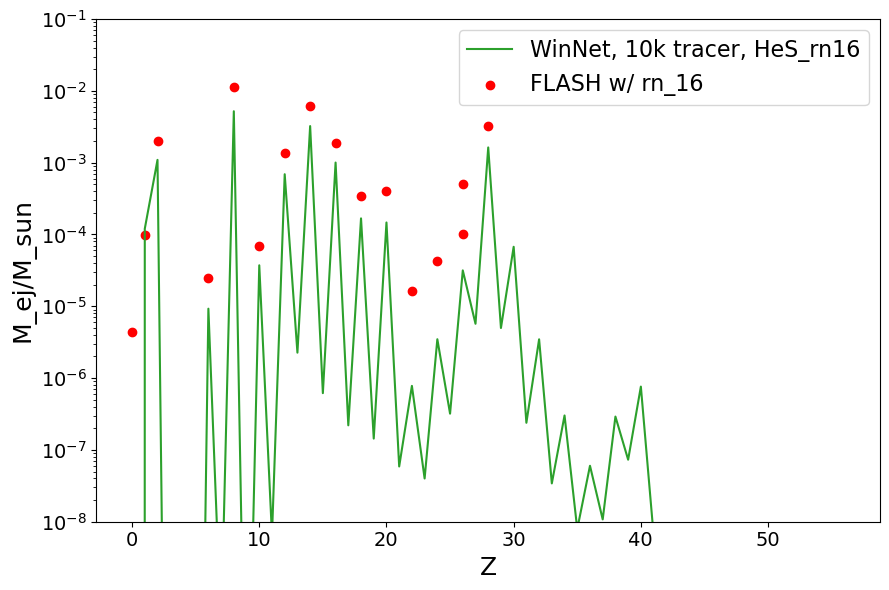

In [227]:
#at 800ms: 

t_index = 0#0 is 800ms, 1 is 1s?, 2 is 1.2s - i think

#no_net
snapdat_792_1k = HeS_2D_1ktr_nf1_7GK_792ms_snapdata[t_index]
finabs_elem_1k = HeS_2D_1ktr_nf1_7GK_792ms_finabselem

snapdat_792_10k = HeS_2D_10ktr_nf1_7GK_792ms_snapdata[t_index]
finabs_elem_10k = HeS_2D_10ktr_nf1_7GK_792ms_finabselem

#rn_16
snapdat_792_1k_rn16 = HeS_2D_1ktr_nf1_7GK_792ms_rn16_snapdata[t_index]
finabs_elem_1k_rn16 = HeS_2D_1ktr_nf1_7GK_792ms_rn16_finabselem

snapdat_792_10k_rn16 = HeS_2D_10ktr_nf1_7GK_792ms_rn16_snapdata[t_index]
finabs_elem_10k_rn16 = HeS_2D_10ktr_nf1_7GK_792ms_rn16_finabselem

#finabs of Z plot:
plt.figure(figsize = (9,6))
#plt.title(f'Composition at {snapdat_800["t"]:.3f}s - only unbound mass')
#2D_10ktr
# plt.plot(snapdat_792_1k['Z'], snapdat_792_1k['X_Z']*HeS_2D_1ktr_nf1_7GK_792ms_total_mass/M_sun_g, label = 'WinNet, 1k tracer, HeS_nonet', ls = '--', c="C1")
# plt.plot(snapdat_792_10k['Z'], snapdat_792_10k['X_Z']*HeS_2D_10ktr_nf1_7GK_792ms_total_mass/M_sun_g, label = 'WinNet, 10k tracer, HeS_nonet', c="C1")

#HeS_rn16
#plt.plot(snapdat_792_1k_rn16['Z'], snapdat_792_1k_rn16['X_Z']*HeS_2D_1ktr_nf1_7GK_792ms_rn16_total_mass/M_sun_g, label = 'WinNet, 1k tracer, HeS_rn16', ls = '--', c="C2")
plt.plot(snapdat_792_10k_rn16['Z'], snapdat_792_10k_rn16['X_Z']*HeS_2D_10ktr_nf1_7GK_792ms_rn16_total_mass/M_sun_g, label = 'WinNet, 10k tracer, HeS_rn16', c="C2")

plt.scatter(HeS_792ms_unbound_composition_fromplt['h1']['Z'], HeS_792ms_unbound_composition_fromplt['h1']['X'] * HeS_792ms_ejec_M_fromplt / M_sun_g,color = 'red', label = 'FLASH w/ rn_16')
for iso in list(HeS_792ms_unbound_composition_fromplt.keys())[1:]:
    plt.scatter(HeS_792ms_unbound_composition_fromplt[iso]['Z'], HeS_792ms_unbound_composition_fromplt[iso]['X'] * HeS_792ms_ejec_M_fromplt / M_sun_g,color = 'red')
# plt.plot(snapdat_900['Z'], snapdat_900['X_Z'], label = '900ms')
# plt.plot(snapdat_1000['Z'], snapdat_1000['X_Z'], label = '1000ms')

# plt.plot(finabs_elem['Z'], finabs_elem['X_Z'], label = 'final composition')


plt.xlabel('Z', fontsize = 18)
plt.ylabel('M_ej/M_sun', fontsize = 18)
plt.ylim(1e-8, 1e-1)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.yscale('log')

plt.tick_params(axis='both', labelsize=14)


plt.tight_layout()

plt.savefig('/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/rn16_WinNet_composition_comparison.png')

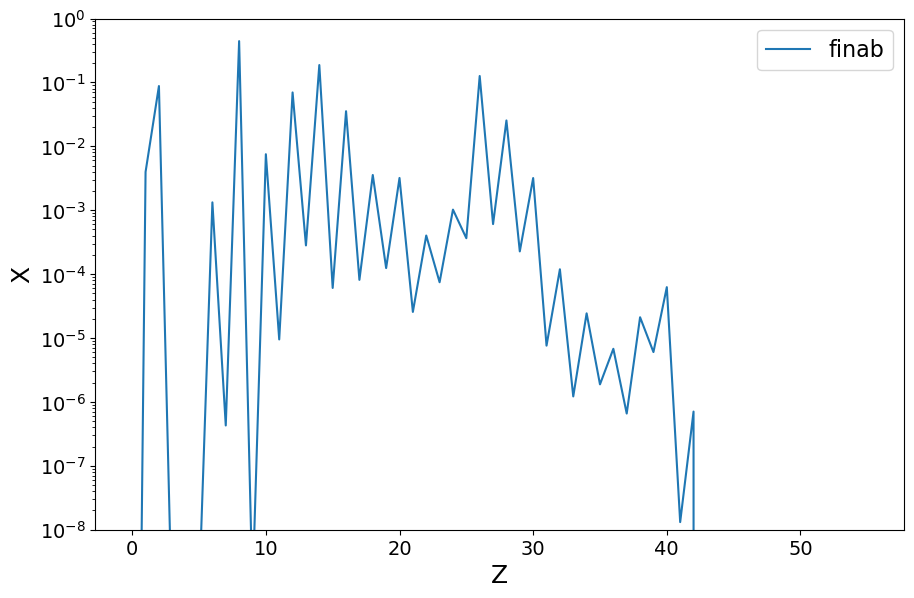

In [112]:
#finab

finabs_elem = HeS_2D_10ktr_nf1_10GK_800ms_finabselem
plt.figure(figsize = (9,6))

#2D_10ktr
plt.plot(finabs_elem['Z'], finabs_elem['X_Z'], label = 'finab')

plt.xlabel('Z', fontsize = 18)
plt.ylabel('X', fontsize = 18)
plt.ylim(1e-8, 1)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.yscale('log')

plt.tick_params(axis='both', labelsize=14)

## 2) Composition and Conditions of the ejecta at NSE freeze out

Here: NSE_temp = 5.8GK

In [21]:
nse_temp = 5.8e9 #K

def quants_at_freezeout(clean_paths_WN_out, list_of_quants, NSE_temp = 5.8e9, want_paths = False):
    masses = []
    freezeout_vals = {key: [] for key in list_of_quants}
    paths = []
    
    for path in tqdm(clean_paths_WN_out):

        obj = WinNet_output(path, want_tracer_info=True)
        
        tr_dat = obj.tracer_data
        units = obj.tracer_data_units

        # Handle 'temp' or 'T'
        if "temp" in tr_dat:
            temp_key = "temp"
        elif "T" in tr_dat:
            temp_key = "T"
        else:
            print("No valid temperature key ('temp' or 'T') in tracer_data")
            continue
        
        # Unit conversion
        if units.get(temp_key, None) == "GK":
            temp_fac = 1e9
        elif units.get(temp_key, None) == "K":
            temp_fac = 1
        else:
            temp_fac = 0
            print("what kinda temperature unit is this :(")

        temps = tr_dat[temp_key] * temp_fac

        if np.max(temps) < NSE_temp:
            continue

        # Find last index where temp drops below NSE_temp
        crosses_NSE_at = np.where((temps[:-1] >= NSE_temp) & (temps[1:] < NSE_temp))[0] + 1

        if len(crosses_NSE_at) == 0:
            # never crossed NSE freezeout
            continue

        final_NSE_freezeout_idx = crosses_NSE_at[-1]
        masses.append(obj.mass)
        paths.append(path)

        for key in list_of_quants:
            freezeout_vals[key].append(np.array(tr_dat[key][final_NSE_freezeout_idx])) #if doesn work - remove np.array(...)

    if want_paths:
        return masses, freezeout_vals, paths
    else:
        return masses, freezeout_vals

In [19]:
#fmts for different tracers:

#get freezeout vals of
vals_2Dfmt = ['ye', 'entr']
vals_1Dfmt = ['Ye', 'entr']

#in what bins to bin:
Ye_bins = np.linspace(0.35,0.65,51)
entr_bins = np.linspace(0, 50, 30)


In [27]:
new_S15_1k_nf1_7GK_masses, new_S15_1k_nf1_7GK_freezeout_vals, new_S15_1k_nf1_7GK_NSEpaths = quants_at_freezeout(new_S15_1k_nf1_7GK_clean, vals_2Dfmt, want_paths=True)

100%|██████████| 2776/2776 [00:14<00:00, 192.50it/s]


In [22]:
S15_2D_1ktr_masses, S15_2D_1ktr_fo_vals = quants_at_freezeout(S15_2D_1ktr_clean, vals_2Dfmt)
S15_1D_750tr_masses, S15_1D_750tr_fo_vals = quants_at_freezeout(S15_1D_750tr_clean, vals_1Dfmt)

  0%|          | 0/2776 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [228]:
"""
HeS rn16 run
"""
HeS_rn16_10k_nf1_10GK_masses,HeS_rn16_10k_nf1_10GK_fo_vals = quants_at_freezeout(HeS_2D_10ktr_nf1_7GK_792ms_clean, vals_2Dfmt)

100%|██████████| 14119/14119 [10:03<00:00, 23.39it/s]


### Histogram plotting functions

In [23]:
def Histo_plot(to_bin_list, bins, label_list, weights_list, xmin, xmax, xlabel, ylabel, save=False, save_name = None):
    plt.hist(to_bin_list, bins, label=label_list, weights=weights_list)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlim(xmin, xmax)
    plt.legend(fontsize=16)
    plt.yscale('log')

    plt.tick_params(axis='both', labelsize=14) 
    
    if save and save_name is not None:
        plt.savefig('/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/' + save_name )


#same but just to call in a multiplot:
def Histo_plot_for_multiplot(ax, to_bin_list, bins, label_list, weights_list, xmin, xmax, xlabel, ylabel):
    # plot on the given axes
    ax.hist(to_bin_list, bins=bins, label=label_list, weights=weights_list)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlim(xmin, xmax)
    ax.legend(fontsize=16)
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=14)


/tmp/ipykernel_3023020/1376980151.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels)


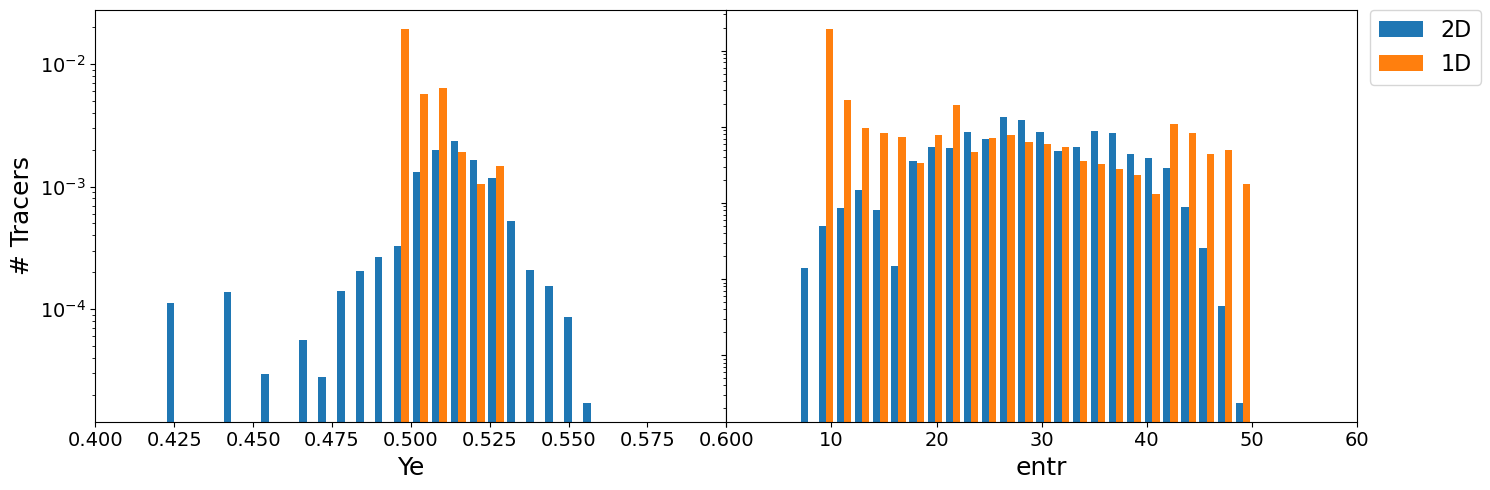

In [28]:
#next to each other: 

fig, ax = plt.subplots(1, 2, figsize = (15, 5), gridspec_kw={'wspace': 0})

Histo_plot_for_multiplot(ax[0], [S15_2D_1ktr_fo_vals['ye'], S15_1D_750tr_fo_vals['Ye']], Ye_bins, ['2D', "1D"],
              [S15_2D_1ktr_masses/M_sun_g, S15_1D_750tr_masses/M_sun_g],
          0.4, 0.6, 'Ye', r'# Tracers')

Histo_plot_for_multiplot(ax[1], [S15_2D_1ktr_fo_vals['entr'], S15_1D_750tr_fo_vals['entr']], entr_bins, ['2D', "1D"],
            [S15_2D_1ktr_masses/M_sun_g, S15_1D_750tr_masses/M_sun_g],
          0.0, 60.0, 'entr', r'# Tracers')

ax[1].set_ylabel('')
ax[1].tick_params(labelleft=False)
ax[0].legend_.remove()
labels = [item.get_text() for item in ax[1].get_xticklabels()]
labels[0] = ''  # blank out the first label
ax[1].set_xticklabels(labels)
ax[1].legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize = 16)

plt.tight_layout()

### Double Histogram from Sieverding Paper

In [29]:
#custom colormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, ListedColormap
import matplotlib.colors as mcolors

# First, create the custom colormap
def create_jet_no_blue_colormap():
    """Create a jet-like colormap without the blue part"""
    # Get the full jet colormap
    jet_full = plt.get_cmap('jet')
    
    # Extract colors from 0.3 to 1.0 (removing the blue portion)
    # You can adjust these values if you want to remove more or less
    start_ratio = 0.35
    end_ratio = 1.0
    
    # Create new colormap
    jet_no_blue = ListedColormap(jet_full(np.linspace(start_ratio, end_ratio, 256)))
    
    return jet_no_blue

# Create the colormap
jet_no_blue = create_jet_no_blue_colormap()

In [30]:
def plot_2D_marginals(Ye, entropy, dm, num_bins=40, figsize=(7.5,6), cmap=None, 
                       Ye_min=None, Ye_max=None, entr_min=None, entr_max=None,
                       save=False, save_name=None):
    """
    Plots a 2D histogram with logarithmic marginal histograms.
    Marginal histograms touch the main plot with no gap.

    ALSO TAKES CUSTOM CMAP DEFINED ABOVE
    """
    Ye = np.array(Ye)
    entropy = np.array(entropy)
    dm = np.array(dm)

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[4,1.5], height_ratios=[1.5,4],
                  wspace=0, hspace=0)  # no space
    
    ax_main = fig.add_subplot(gs[1,0])
    ax_xhist = fig.add_subplot(gs[0,0], sharex=ax_main)
    ax_yhist = fig.add_subplot(gs[1,1], sharey=ax_main)
    
    # define bin edges
    if Ye_min is None: Ye_min = Ye.min()
    if Ye_max is None: Ye_max = Ye.max()
    if entr_min is None: entr_min = entropy.min()
    if entr_max is None: entr_max = entropy.max()

    Ye_edges = np.linspace(Ye_min, Ye_max, num_bins+1)
    entropy_edges = np.linspace(entr_min, entr_max, num_bins+1)

    # Use the custom colormap if none provided
    if cmap is None:
        cmap = jet_no_blue

    # 2D histogram
    hb = ax_main.hist2d(Ye, entropy, bins=[Ye_edges, entropy_edges], weights=dm, cmap=cmap,
                        norm=LogNorm())
    
    # marginal histograms
    ax_xhist.bar((Ye_edges[:-1] + Ye_edges[1:])/2,
                 np.histogram(Ye, bins=Ye_edges, weights=dm)[0],
                 width=np.diff(Ye_edges), edgecolor='blue')
    ax_yhist.barh((entropy_edges[:-1] + entropy_edges[1:])/2,
                  np.histogram(entropy, bins=entropy_edges, weights=dm)[0],
                  height=np.diff(entropy_edges), edgecolor='blue')
    
    # logarithmic scales for marginals
    ax_xhist.set_yscale('log')
    ax_yhist.set_xscale('log')
    
    # hide tick labels on marginals
    plt.setp(ax_xhist.get_xticklabels(), visible=False)
    plt.setp(ax_yhist.get_yticklabels(), visible=False)
    
    # increase font sizes
    label_fs = 18
    tick_fs = 14
    ax_main.set_xlabel(r"$Y_e$", fontsize=label_fs)
    ax_main.set_ylabel("Entropy [kB/baryon]", fontsize=label_fs)
    ax_xhist.set_ylabel(r"$M \,[M_\odot]$", fontsize=label_fs)
    ax_yhist.set_xlabel(r"$M \,[M_\odot]$", fontsize=label_fs)
    ax_main.tick_params(axis='both', labelsize=tick_fs)
    ax_xhist.tick_params(axis='y', labelsize=tick_fs)
    ax_yhist.tick_params(axis='x', labelsize=tick_fs)
    
    # set axis limits
    ax_main.set_xlim(Ye_min, Ye_max)
    ax_main.set_ylim(entr_min, entr_max)
    ax_xhist.set_xlim(Ye_min, Ye_max)
    ax_yhist.set_ylim(entr_min, entr_max)
    
    # remove top/bottom and left/right spines to make touching perfect
    ax_xhist.spines['bottom'].set_visible(False)
    ax_yhist.spines['left'].set_visible(False)

    # colorbar
    cbar = fig.colorbar(hb[3], ax=[ax_main, ax_xhist, ax_yhist], shrink=0.8, pad=0.05)
    cbar.set_label(r"$M\,[M_\odot]$", fontsize=label_fs)
    cbar.ax.tick_params(labelsize=tick_fs)
    
    if save and save_name is not None:
        plt.savefig("/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/" + save_name)
    
    plt.show()

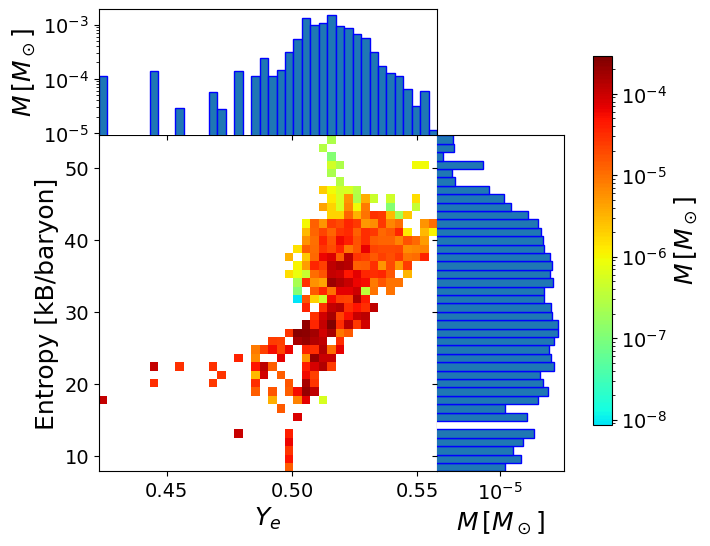

In [31]:
plot_2D_marginals(S15_2D_1ktr_fo_vals['ye'], S15_2D_1ktr_fo_vals['entr'], dm=S15_2D_1ktr_masses/M_sun_g, save=False, save_name='')

In [ ]:
plot_2D_marginals(S15_1D_750tr_fo_vals['Ye'], S15_1D_750tr_fo_vals['entr'], dm=S15_1D_750tr_masses/M_sun_g, save=False, save_name='')

## 3) Neutrino Processed Tracers

Following the definition of Max Witt abs(ye(t0) - ye(tf)) > 0.01 we find the neutrinos whose composition (p  vs n) where influences by the interaction/absorption of electron type neutrinos from the cooling PNS

### get nu processed tracers

In [77]:
def tracer_nu_processed(WN_obj_clean_path_list):

    nu_processed_paths = []

    for path in tqdm(WN_obj_clean_path_list):
        
        WN_obj = WinNet_output(path, want_tracer_info=True)
        
        #care made for ascending time ordering
        Ye_arr = WN_obj.tracer_data['ye']
    
        if abs(np.max(Ye_arr) - np.min(Ye_arr)) > 0.01: #ye changed by neutrino interaction --> nu procced
            nu_processed_paths.append(path)

    return nu_processed_paths

#### old S15

In [18]:
#Get number of neutrino processed tracers with both placement methods and check if their summed up mass is still the same (roughly)

nu_processed_10k = [tracer_nu_processed(WN_path) for WN_path in S15_2D_10ktr_nf0_10GK_clean]

In [17]:
nu_processed_10k_yecrit = [tracer_nu_processed(WN_path) for WN_path in tqdm(S15_2D_10ktr_nf0_10GK_yecrit_clean)]

100%|██████████| 13662/13662 [01:15<00:00, 179.85it/s]


In [19]:
nu_processed_10k = np.array(nu_processed_10k)
nu_processed_10k_yecrit = np.array(nu_processed_10k_yecrit)

In [204]:
print(len(nu_processed_paths_new))

4025


In [20]:
total_true_old = np.sum(nu_processed_10k)
total_true_new = np.sum(nu_processed_10k_yecrit)

print(f'old placement: {total_true_old}, new placement: {total_true_new}')

old placement: 1292, new placement: 4025


In [21]:
#Care index in clean paths not necessarily tr_id
indices_old = np.where(nu_processed_10k)[0]
indices_new = np.where(nu_processed_10k_yecrit)[0]


In [22]:
nu_processed_paths_old = np.array(S15_2D_10ktr_nf0_10GK_clean)[indices_old]
nu_processed_paths_new = np.array(S15_2D_10ktr_nf0_10GK_yecrit_clean)[indices_new]

#### new S15 (fixed bug)

In [78]:
nu_processed_paths = tracer_nu_processed(new_S15_1k_nf1_7GK_clean)

  0%|          | 0/2776 [00:00<?, ?it/s]

In [79]:
print(len(nu_processed_paths))

1790


#### Plot Ye tracer AND mainout for all nu processed tracers

In [101]:
ye_tr_list = []
ye_mo_list = []
t0_30T9_list = []
t0_10T9_list = []
t0_7T9_list = []

for path in tqdm(nu_processed_paths):
    WN_out = WinNet_output(path, want_mainout_info=True,want_tracer_info=True)


    T = WN_out.tracer_data['temp']

    crossings7 = np.where((T[:-1] >= 7) & (T[1:] < 7))[0]
    last_7_idx = crossings7[-1] + 1 if crossings7.size > 0 else 0
    t0_7T9_list.append(WN_out.tracer_data['t'][last_7_idx])
    
    crossings10 = np.where((T[:-1] >= 10) & (T[1:] < 10))[0]
    last_10_idx = crossings10[-1] + 1 if crossings10.size > 0 else 0
    t0_10T9_list.append(WN_out.tracer_data['t'][last_10_idx])

    crossings30 = np.where((T[:-1] >= 30) & (T[1:] < 30))[0]
    last_30_idx = crossings30[-1] + 1 if crossings30.size > 0 else 0
    t0_30T9_list.append(WN_out.tracer_data['t'][last_30_idx])

    ye_tr_list.append([WN_out.tracer_data['t'], WN_out.tracer_data['ye']])
    ye_mo_list.append([WN_out.mainout_data['time'], WN_out.mainout_data['Ye']])

  0%|          | 0/1790 [00:00<?, ?it/s]

In [164]:
start = end = 218

/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/new_S15_1ktr_bwd_nf1_7GK/00493


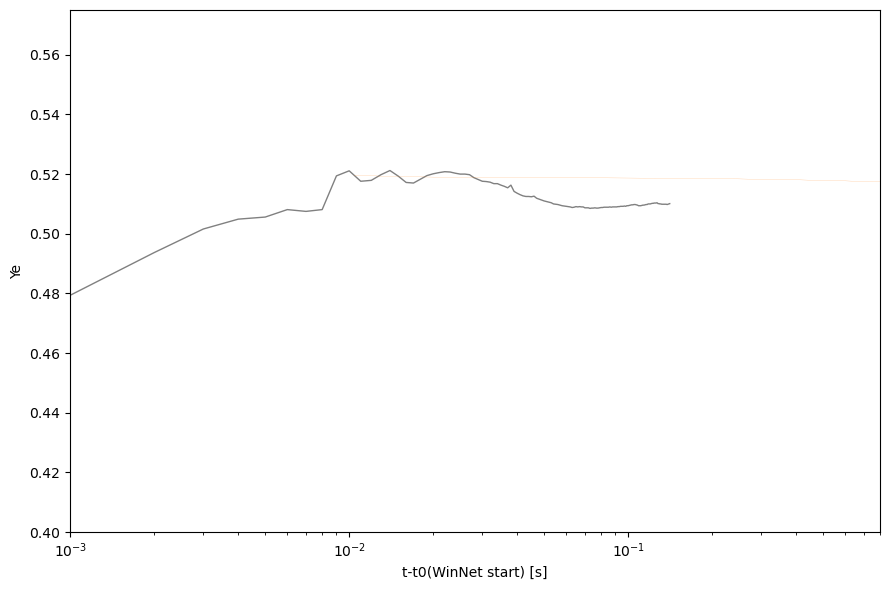

In [165]:
t0_list = t0_30T9_list

plt.figure(figsize = (9,6))


for tr_id in range(len(ye_tr_list)):

    if tr_id < start or tr_id > end:
        continue
    
    if t0_list[tr_id] == 0:
        continue
    # print(t0_list[tr_id])
    # print(ye_tr_list[tr_id][0]-t0_list[tr_id])
    plt.plot(ye_tr_list[tr_id][0]-t0_list[tr_id], ye_tr_list[tr_id][1], color = 'grey', linewidth = 1)
    plt.plot(ye_mo_list[tr_id][0]-t0_list[tr_id], ye_mo_list[tr_id][1], color = 'C1', linewidth = 0.1)

    print(nu_processed_paths[start])

plt.xlabel('t-t0(WinNet start) [s]')
plt.xscale('log')
plt.xlim(1e-3, 0.8)

plt.ylim(0.4, 0.575)
plt.ylabel('Ye')


plt.tight_layout()

start += 1 
end += 1

#plt.savefig('/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/PfA_all_ye.png')

#### No idead what i used this for

In [23]:
#extract end positons (pos(tmax)) to plot against each other

def extract_NSE_ye_entr_endpos(paths_to_WN_out):

    reached_NSE = np.zeros(len(paths_to_WN_out))
    NSE_ye = np.full(len(paths_to_WN_out), np.nan)
    NSE_entr = np.full(len(paths_to_WN_out), np.nan)
    masses = np.zeros(len(paths_to_WN_out))
    end_x = np.zeros(len(paths_to_WN_out))
    end_y = np.zeros(len(paths_to_WN_out))
    
    for i, path in enumerate(tqdm(paths_to_WN_out)):
        WN_out = WinNet_output(path, want_tracer_info=True)

        temps = WN_out.tracer_data['temp'] 
        
        if max(temps > 5.8):
            reached_NSE[i] = True

            crosses_NSE_at = np.where((temps[:-1] >= 5.8) & (temps[1:] < 5.8))[0] + 1

            if len(crosses_NSE_at) == 0:
                # never crossed NSE freezeout
                continue
            
            last_NSE_crossing_idx = crosses_NSE_at[-1]
            NSE_ye[i] = WN_out.tracer_data['ye'][last_NSE_crossing_idx]
            NSE_entr[i] = WN_out.tracer_data['entr'][last_NSE_crossing_idx]

        masses[i] = WN_out.mass
        end_x[i] = WN_out.tracer_data['x'][-1]
        end_y[i] = WN_out.tracer_data['y'][-1]

    return reached_NSE, NSE_ye, NSE_entr, masses, end_x, end_y

In [24]:
reached_NSE_old, NSE_ye_old, NSE_entr_old, masses_old, end_x_old, end_y_old = extract_NSE_ye_entr_endpos(nu_processed_paths_old)

100%|██████████| 1292/1292 [00:09<00:00, 140.98it/s]


In [25]:
reached_NSE_new, NSE_ye_new, NSE_entr_new, masses_new, end_x_new, end_y_new = extract_NSE_ye_entr_endpos(nu_processed_paths_new)

100%|██████████| 4025/4025 [00:30<00:00, 131.11it/s]


In [26]:
print(f'Old placement: sum of the masses of nu processed tracers: {sum(masses_old)/M_sun_g} ' + r"M$_\odot$")
print(f'New placement: sum of the masses of nu processed tracers: {sum(masses_new)/M_sun_g} ' + r"M$_\odot$")
print(f'relative: {sum(masses_old/sum(masses_new))}')

Old placement: sum of the masses of nu processed tracers: 0.010295592087273793 M$_\odot$
New placement: sum of the masses of nu processed tracers: 0.010189663479623549 M$_\odot$
relative: 1.010395692444806


### Find the tracers with the most extreme ye values to further analyze in analyze_single notebook

In [37]:
def find_tracers_with_val_in_interval(quants_at_freezeout, threshold_value_min, threshold_value_max):

    vals_list = []
    index_list = []
    
    for i, value in tqdm(enumerate(quants_at_freezeout)):
        if threshold_value_min < value < threshold_value_max:
            vals_list.append(value)
            index_list.append(i)

    if len(vals_list) == 0:
        print('No such tracers found')
    else:
        return np.array(vals_list), np.array(index_list)

In [38]:
def find_tracers_in_ye_entr_intervals(ye_at_fo_arr, entr_at_fo_arr, ye_min, ye_max, entr_min, entr_max):
    ye_list = []
    entr_list = []
    index_list = []

    if len(ye_at_fo_arr) == len(entr_at_fo_arr):
        for i in range(len(ye_at_fo_arr)):
            if ye_min < ye_at_fo_arr[i] < ye_max and entr_min < entr_at_fo_arr[i] < entr_max:
                ye_list.append(ye_at_fo_arr[i])
                entr_list.append(entr_at_fo_arr[i])
                index_list.append(i)
    else:
        print("entr list and ye list have to be the same size")

    return ye_list, entr_list, index_list

#### (old S15)

In [208]:
ye_053_054_entr_37_38_out = find_tracers_in_ye_entr_intervals(S15_2D_10ktr_nf0_10GK_yecrit_fo_vals['ye'], S15_2D_10ktr_nf0_10GK_yecrit_fo_vals['entr'], 0.53, 0.54, 37, 38)

In [35]:
low_ye_vals, indicies_low = find_tracers_with_val_in_interval(S15_2D_10ktr_nf0_10GK_yecrit_fo_vals['ye'], 0.4, 0.45)

3671it [00:00, 336163.35it/s]


In [36]:
print(low_ye_vals)
print(np.array(S15_2D_10ktr_nf0_10GK_ye_crit_NSE_paths)[indicies_low])

[0.4277 0.428  0.4488 0.4354 0.4356 0.4431 0.4409 0.4238]
['/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00060'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00373'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00497'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00546'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00547'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/02364'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/10330'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_1

In [253]:
ye_045_046_vals, indices_045_046 = find_tracers_with_val_in_interval(S15_2D_10ktr_nf0_10GK_yecrit_fo_vals['ye'], 0.45, 0.46)

3672it [00:00, 368818.32it/s]


In [254]:
print(ye_045_046_vals)
print(np.array(S15_2D_10ktr_nf0_10GK_ye_crit_NSE_paths)[indices_045_046])

[0.4514 0.4594 0.4584 0.4599 0.4522 0.458 ]
['/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00442'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00476'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00507'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/00748'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/02386'
 '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10000tr_bwd_nf0_10GK_yecrit/05165']


#### new S15

In [39]:
ye_04_043_entr_10_20_S15_1k_nf1_7GK_new = find_tracers_in_ye_entr_intervals(new_S15_1k_nf1_7GK_freezeout_vals['ye'], new_S15_1k_nf1_7GK_freezeout_vals['entr'], 0.4, 0.43, 10, 20) 

In [44]:
print((ye_04_043_entr_10_20_S15_1k_nf1_7GK_new))

print(new_S15_1k_nf1_7GK_NSEpaths[ye_04_043_entr_10_20_S15_1k_nf1_7GK_new[2][0]])

([array(0.4229)], [array(18.1024)], [166])
/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/new_S15_1ktr_bwd_nf1_7GK/00296


#### find all tracers where ye from the tracer differs from the WN out - due to mixing/or something else ?

In [37]:
def find_diffs_ye(WN_out_paths, max_difference):

    differences = []
    paths_to_WN_out = []
    total_mass = 0
    
    for path in tqdm(WN_out_paths):
        WN_obj = WinNet_output(path, want_mainout_info=True, want_tracer_info=True)

        final_tr_time = WN_obj.tracer_data['t'][-1]
        idx_in_mainout = np.searchsorted( WN_obj.mainout_data['time'], final_tr_time)

        if np.abs(WN_obj.tracer_data['ye'][-1] - WN_obj.mainout_data['Ye'][idx_in_mainout]) > max_difference:
            differences.append(np.abs(WN_obj.tracer_data['ye'][-1] - WN_obj.mainout_data['Ye'][idx_in_mainout]))
            paths_to_WN_out.append(path)
            total_mass += WN_obj.mass

    return differences, paths_to_WN_out, total_mass

In [38]:
diffs, paths, tot_m = find_diffs_ye(S15_2D_10ktr_nf0_10GK_ye_crit_NSE_paths, 0.02)

100%|██████████| 3671/3671 [03:28<00:00, 17.58it/s]


In [39]:
print(len(diffs))

367


In [40]:
print(tot_m/M_sun_g)

0.0014873569275944847


In [284]:
def save_weird_yes(paths):
    for path in paths:

        plt.figure(figsize = (9,6))
        
        WN_out = WinNet_output(path, want_mainout_info=True, want_tracer_info=True)

        plt.plot(WN_out.mainout_data['time']-WN_out.tracer_data["t"][0], WN_out.mainout_data['Ye'], label = 'WinNet')
        plt.plot(WN_out.tracer_data["t"]-WN_out.tracer_data["t"][0], WN_out.tracer_data["ye"], label ='FLASH', linestyle = "--")
        plt.xlabel(f't [{WN_out.mainout_data_units["time"]}]')
        plt.ylabel(f'Y_e [{WN_out.mainout_data_units["Ye"]}]')
        plt.xscale('log')
        plt.ylim(0.38, 0.62)
        plt.xlim(1e-2, 10)

        plt.title(f'Tracer {WN_out.tracer_id}, M = {WN_out.mass/M_sun_g} M_sun')
        
        plt.tight_layout()
        plt.savefig(f'/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/ye_comparison/tracer_{WN_out.tracer_id:05d}.png')
        plt.close()

In [41]:
#save_weird_yes(paths)

In [51]:
def plot_finabs_multiple(paths):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))

    Zs = np.arange(0, 120)
    Msum_of_Z = np.zeros(len(Zs))
    
    for path in paths:
        
        WN = WinNet_output(path, want_finabs_info=True, want_tracer_info=True)
        Msum_of_Z[WN.finabelem['Z']] += WN.finabelem["X"]*WN.mass/M_sun_g 
        ax[0].plot(WN.finabelem["Z"], WN.finabelem["X"], color = 'gray', linewidth=0.2)
    
    ax[0].set_xlabel('Z')
    ax[0].set_ylabel('X')
    ax[0].set_yscale('log')
    ax[0].set_ylim(1e-8, 1)

    ax[1].plot(Zs, Msum_of_Z)
    ax[1].set_xlabel('Z')
    ax[1].set_ylabel('M/M_sun')
    ax[1].set_yscale('log')
    ax[1].set_ylim(1e-10, 1e-2)
    ax[1].set_xlim(0, 60)
    
    plt.tight_layout()
    
    plt.show()

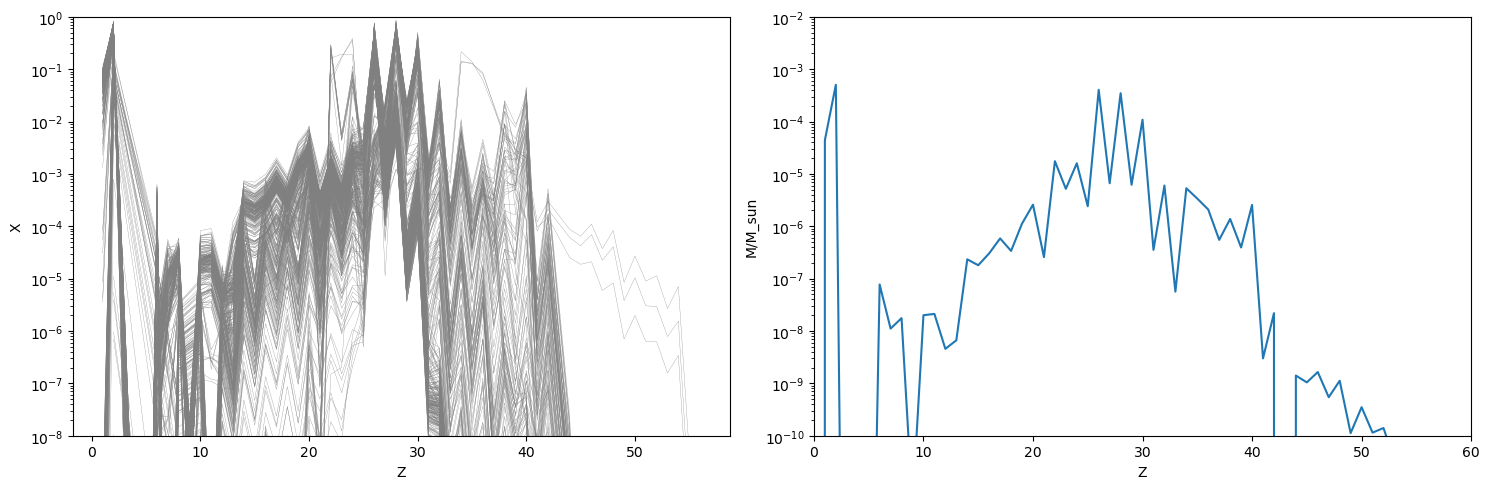

In [52]:
plot_finabs_multiple(paths)